# Task 3

First we import the libraries we will use:

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

We create the method `get_samples` which will simply generate two classes of samples (with their labels):

In [28]:
def get_samples(nb_features = 20, mean0 = 2, mean1 = 1.3, nb_samples0 = 2000, nb_samples1 = 2000):
    mean0_array = [mean0] * nb_features
    mean1_array = [mean1] * nb_features
    cov = np.identity(nb_features)
    samples0_features = np.random.multivariate_normal(mean0_array, cov, nb_samples0)
    samples1_features = np.random.multivariate_normal(mean1_array, cov, nb_samples1)
    
    labels0 = [0] * nb_samples0
    labels1 = [1] * nb_samples1
    return samples0_features, samples1_features, labels0, labels1

We create the method `get_train_test` which will generate the training and testing sets with their labels:

In [15]:
def get_train_test(nb_features = 20, mean0 = 2, mean1 = 1.3, nb_samples0 = 2000, nb_samples1 = 2000):
    features0, features1, labels0, labels1 = get_samples(nb_features, mean0, mean1, nb_samples0, nb_samples1)
    features0_train, features0_test, labels0_train, labels0_test = train_test_split(features0, labels0, test_size = 0.3)
    features1_train, features1_test, labels1_train, labels1_test = train_test_split(features1, labels1, test_size = 0.3)
    
    X_train = np.append(features0_train, features1_train, axis=0)
    X_test = np.append(features0_test, features1_test, axis=0)
    y_train = labels0_train + labels1_train
    y_test = labels0_test + labels1_test
    
    return X_train, X_test, y_train, y_test

In [31]:
X_train, X_test, y_train, y_test = get_train_test()

Now we create a function which takes the range of k values to test as argument and returns the model which achieved the best score, along with all the train and test scores:

In [81]:
def get_scores(X_train, X_test, y_train, y_test, k_range = range(1, 200)):
    result_train = []
    result_test = []
    best_test_score = 0
    for k in k_range:
        if k % 100 == 0:
            print("k = {}".format(k))
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        train_score = knn.score(X_train, y_train)
        result_train.append(train_score)
        test_score = knn.score(X_test, y_test)
        result_test.append(test_score)
        
        if test_score > best_test_score:
            best_test_score = test_score
            best_model = knn
    return result_train, result_test, best_model

We train that model and test it for all values of k between 1 and 500 (inclusive)

In [56]:
k_range = range(1, 500)
train_score, test_score, best_knn = get_scores(X_train, X_test, y_train, y_test, k_range)

k = 100
k = 200
k = 300
k = 400


We plot the test score depending on k:

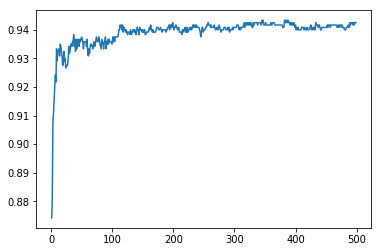

In [57]:
plt.plot(k_range, test_score)

Discussion: we see that, roughly for the first 150 values of `k`, the test score is increasing but then it remains flat on average for all the values between 200 and 500. 

Possible approaches for finding the best values of `k` are more or less the same as for other classifiers. What I did is trying all values of `k` in a specific range. However, this can be computationally expensive when we have a lot of features/samples. Another famous approach is to use a logarithmic scale of values for `k`. For example:

In [69]:
k_values = np.logspace(1, 3, dtype="int", num=30)
print(k_values)

[  10   11   13   16   18   22   25   30   35   41   48   57   67   78   92
  108  126  148  174  204  239  280  329  385  452  529  621  727  853 1000]


Once we find the best values among those ones we can try to "look around it" to see if there is a better value.

Let's print the score metrics:

In [64]:
predictions = best_knn.predict(X_test)
f1 = f1_score(predictions, y_test)
precision = precision_score(predictions, y_test)
recall = recall_score(predictions, y_test)
print("f1 score is {}".format(f1))
print("precision score is {}".format(precision))
print("recall score is {}".format(recall))

f1 score is 0.9435215946843853
precision score is 0.9466666666666667
recall score is 0.9403973509933775


We see that the three values are very close to each other. This was expected because the number of samples was the same for both classes.

### Unbalanced samples case

Now let us try the second situation where we only have 100 samples in the second class:

In [70]:
X_train, X_test, y_train, y_test = get_train_test(nb_samples1=100)

Let's train our model the same way we did before:

In [83]:
result_train, result_test, best_knn_unbalanced = get_scores(X_train, X_test, y_train, y_test, k_range)

k = 100
k = 200
k = 300
k = 400


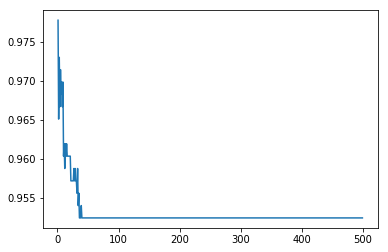

In [77]:
plt.plot(k_range, result_test)

This time the model seems to perform "better" for lower values of `k`. Once it has reached a threshold value then it flattens out completely ! Why is that ? Well, there are only 100 samples from class 1 and only 70 training samples. So at some point the classifier will just classify all points as class 0 points and always get an accuracy of 0.952 (`2000 / (2000 + 100)`).

The main issue here is that the classes are unbalanced. If there are two classes, one with 2000 samples and the other with 100 samples, then why not just output the first class each time ? This is almost exactly what the model does. It still performs a little better for smaller `k` values, where it manages to classify some class 1 points correctly since the number of neighbors is smaller.

Fortunately, accuracy is not the only metric for testing a model. Let's see what the other measures give:

In [82]:
predictions = best_knn_unbalanced.predict(X_test)
f1 = f1_score(predictions, y_test)
precision = precision_score(predictions, y_test)
recall = recall_score(predictions, y_test)
print("f1 score is {}".format(f1))
print("precision score is {}".format(precision))
print("recall score is {}".format(recall))

f1 score is 0.7083333333333334
precision score is 0.5666666666666667
recall score is 0.9444444444444444


We see that precision is quite low in fact. Precision and recall are two score measures whose purpose is to make sure we don't fall in the trap of thinking that our model is performing good while the classes are just unbalanced. For more detail you can look at the (sklearn documentation)[https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html].

**How to deal with this problem:** Well, there are several ways we could deal with this. One of them might be to simply copy the samples from the minority class until both classes have the same number of samples.

### Time taken for the question
Approximately 1h30